In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
import cv2 as cv
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

tqdm.pandas()

In [2]:
RAW_PATH = 'D:/Workshop/PhD/Data/ViaLactea/PPMAP_Results'

In [3]:
no_tiles = len(os.listdir(RAW_PATH))
no_tiles

163

In [4]:
temps = {
    '01':8,
    '02':9.45024,
    '03':11.1634,
    '04':13.1871,
    '05':15.5776,
    '06':18.4015,
    '07':21.7373,
    '08':25.6779,
    '09':30.3328,
    '10':35.8315,
    '11':42.3270,
    '12':50
}

temp_filters = [12.1,14.3,16.9,20,23.6]

temp_values = np.array([float(v) for v in temps.values()])

conditions = [
    temp_values<=12.1,
    (temp_values>12.1) & (temp_values<=14.3),
    (temp_values>14.3) & (temp_values<=16.9),
    (temp_values>16.9) & (temp_values<=20.0),
    (temp_values>20.0) & (temp_values<=23.6),
    temp_values > 23.6
]
conditions

[array([ True,  True,  True, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False,  True, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False,  True, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False,  True, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, False,  True, False, False,
        False, False, False]),
 array([False, False, False, False, False, False, False,  True,  True,
         True,  True,  True])]

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [42:26<00:00, 509.25s/it]


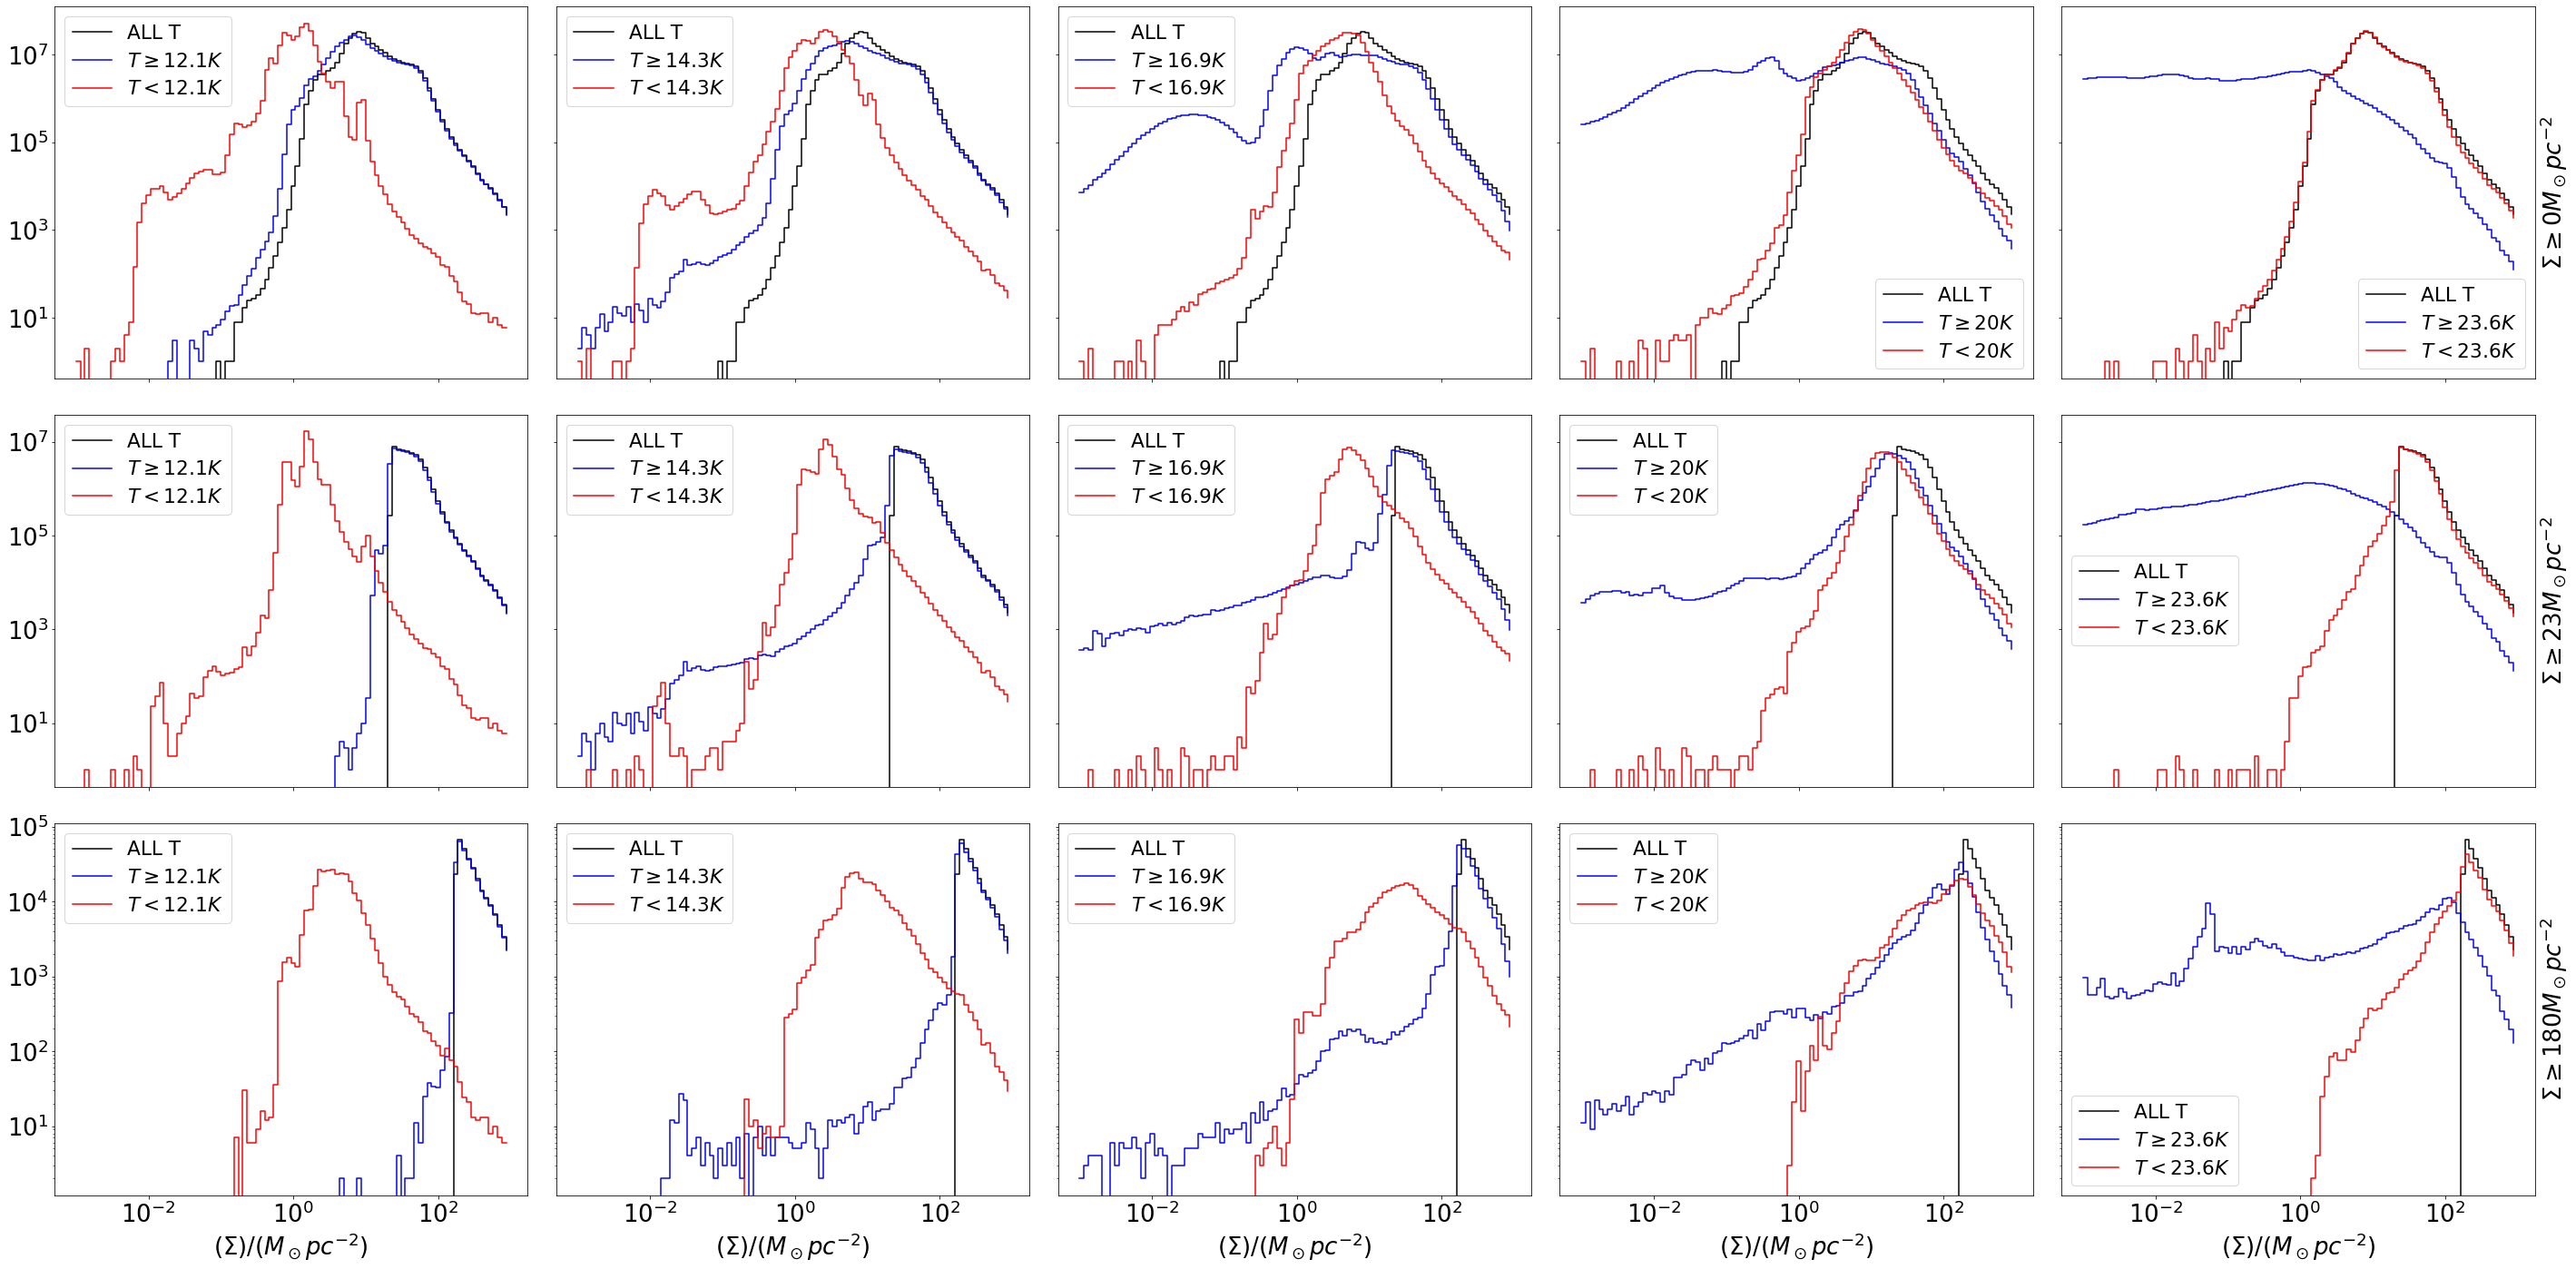

In [98]:
plt.rcParams.update({'font.size': 26})

f,ax = plt.subplots(3,5, figsize = (40,20), sharex=True, sharey='row')

# all surface densities
N_bins = 100
alpha = 0.3

bins = np.logspace(np.log10(0.001),np.log10(1000),N_bins)

for i,temp_filter in enumerate(tqdm(temp_filters)):
    sub_hist_cdens = []
    sub_hist_hot = []
    sub_hist_cold = []
    for tile_folder in os.listdir(RAW_PATH):

        tilename = tile_folder[:4]
        cdens_hdu = fits.open(f'{RAW_PATH}/{tile_folder}/{tilename}_cdens.fits')[0]
        diffcdens_hdu = fits.open(f'{RAW_PATH}/{tile_folder}/{tilename}_diffcdens.fits')[0]
        cdens_hdu.data = cdens_hdu.data/2.72 #convert units from 10^20cm^-2 to M_sun pc^-2
        diffcdens_hdu.data = diffcdens_hdu.data/2.72 #convert units from 10^20cm^-2 to M_sun pc^-2
        cdens_hdu.header['BUNIT'] = 'M_sun pc^-2'
        diffcdens_hdu.header['BUNIT'] = 'M_sun pc^-2'

        temp_df = pd.DataFrame()
        temp_df['cdens'] = cdens_hdu.data.flatten()
        
        for entry in temps:
            temp_df[temps[entry]] = diffcdens_hdu.data[int(entry)-1].flatten()
        temp_df= temp_df.dropna()
        
        filtered_df = pd.DataFrame()
        filtered_df['cdens'] = temp_df['cdens']
        temp_df = temp_df.drop(columns = ['cdens'])

        columns = temp_df.columns.astype(float)
        
        filtered_df['cold'] = temp_df.loc[:,temp_values<temp_filter].sum(axis=1)
        filtered_df['hot'] = temp_df.loc[:,temp_values>=temp_filter].sum(axis=1)
        
        sub_hist_cdens_temp, _ = np.histogram(filtered_df['cdens'], bins = bins)
        sub_hist_cdens.append(sub_hist_cdens_temp)
        
        sub_hist_hot_temp, _ = np.histogram(filtered_df['hot'], bins = bins)
        sub_hist_hot.append(sub_hist_hot_temp)
        
        sub_hist_cold_temp, _ = np.histogram(filtered_df['cold'], bins = bins)
        sub_hist_cold.append(sub_hist_cold_temp)

        
    hist_sum_cdens = np.array(sub_hist_cdens).sum(axis=0)
    hist_sum_hot = np.array(sub_hist_hot).sum(axis=0)
    hist_sum_cold = np.array(sub_hist_cold).sum(axis=0)
    
    ax[0,i].step(bins[:-1], hist_sum_cdens, where='post', c= 'k',
                 label = 'ALL T'
                )
    ax[0,i].step(bins[:-1], hist_sum_hot, where='post', c= 'blue',
                 label = fr'$T\geq{temp_filter}K$'
                )
    ax[0,i].step(bins[:-1], hist_sum_cold, where='post', c= 'red',
                 label = fr'$T<{temp_filter}K$'
                )
    
    ax[0,i].set_xscale('log')
    ax[0,i].set_yscale('log')
    ax[0,i].tick_params(
        axis='y',
        which='both',
        left = True,
        right = False,
        labelleft = False
    )
    ax[0,i].legend(fontsize = 'small')
    
ax[0,-1].set_ylabel(r'$\Sigma \geq 0 M_\odot pc^{-2}$')
ax[0,-1].yaxis.set_label_position("right")

ax[0,0].tick_params(
    axis='y',
    which='both',
    left = True,
    right = False,
    labelleft = True
)
    
# Sigms > 23 M_sun pc^-2

for i,temp_filter in enumerate(tqdm(temp_filters)):
    sub_hist_cdens = []
    sub_hist_hot = []
    sub_hist_cold = []
    for tile_folder in os.listdir(RAW_PATH):

        tilename = tile_folder[:4]
        cdens_hdu = fits.open(f'{RAW_PATH}/{tile_folder}/{tilename}_cdens.fits')[0]
        diffcdens_hdu = fits.open(f'{RAW_PATH}/{tile_folder}/{tilename}_diffcdens.fits')[0]
        cdens_hdu.data = cdens_hdu.data/2.72 #convert units from 10^20cm^-2 to M_sun pc^-2
        diffcdens_hdu.data = diffcdens_hdu.data/2.72 #convert units from 10^20cm^-2 to M_sun pc^-2
        cdens_hdu.header['BUNIT'] = 'M_sun pc^-2'
        diffcdens_hdu.header['BUNIT'] = 'M_sun pc^-2'

        temp_df = pd.DataFrame()
        temp_df['cdens'] = cdens_hdu.data.flatten()

        for entry in temps:
            temp_df[temps[entry]] = diffcdens_hdu.data[int(entry)-1].flatten()
        temp_df= temp_df.dropna()
        
        filtered_df = pd.DataFrame()
        filtered_df['cdens'] = temp_df['cdens']
        temp_df = temp_df.drop(columns = ['cdens'])

        columns = temp_df.columns.astype(float)
        
        filtered_df['cold'] = temp_df.loc[:,temp_values<temp_filter].sum(axis=1)
        filtered_df['hot'] = temp_df.loc[:,temp_values>=temp_filter].sum(axis=1)
        
        filtered_df = filtered_df[filtered_df['cdens']>=23]
        
        sub_hist_cdens_temp, _ = np.histogram(filtered_df['cdens'], bins = bins)
        sub_hist_cdens.append(sub_hist_cdens_temp)
        
        sub_hist_hot_temp, _ = np.histogram(filtered_df['hot'], bins = bins)
        sub_hist_hot.append(sub_hist_hot_temp)
        
        sub_hist_cold_temp, _ = np.histogram(filtered_df['cold'], bins = bins)
        sub_hist_cold.append(sub_hist_cold_temp)


    hist_sum_cdens = np.array(sub_hist_cdens).sum(axis=0)
    hist_sum_hot = np.array(sub_hist_hot).sum(axis=0)
    hist_sum_cold = np.array(sub_hist_cold).sum(axis=0)
    
    ax[1,i].step(bins[:-1], hist_sum_cdens, where='post', c= 'k',
                 label = 'ALL T'
                )
    ax[1,i].step(bins[:-1], hist_sum_hot, where='post', c= 'blue',
                 label = fr'$T\geq{temp_filter}K$'
                )
    ax[1,i].step(bins[:-1], hist_sum_cold, where='post', c= 'red',
                 label = fr'$T<{temp_filter}K$'
                )
    
    
    ax[1,i].set_xscale('log')
    ax[1,i].set_yscale('log')
    ax[1,i].tick_params(
        axis='y',
        which='both',
        left = True,
        right = False,
        labelleft = False
    )
    ax[1,i].legend(fontsize = 'small')
    
ax[1,-1].set_ylabel(r'$\Sigma \geq 23 M_\odot pc^{-2}$')
ax[1,-1].yaxis.set_label_position("right")
ax[1,0].tick_params(
        axis='y',
        which='both',
        left = True,
        right = False,
        labelleft = True
    )

# Sigma > 180 M_sun pc^-2

for i,temp_filter in enumerate(tqdm(temp_filters)):
    sub_hist_cdens = []
    sub_hist_hot = []
    sub_hist_cold = []
    for tile_folder in os.listdir(RAW_PATH):

        tilename = tile_folder[:4]
        cdens_hdu = fits.open(f'{RAW_PATH}/{tile_folder}/{tilename}_cdens.fits')[0]
        diffcdens_hdu = fits.open(f'{RAW_PATH}/{tile_folder}/{tilename}_diffcdens.fits')[0]
        cdens_hdu.data = cdens_hdu.data/2.72 #convert units from 10^20cm^-2 to M_sun pc^-2
        diffcdens_hdu.data = diffcdens_hdu.data/2.72 #convert units from 10^20cm^-2 to M_sun pc^-2
        cdens_hdu.header['BUNIT'] = 'M_sun pc^-2'
        diffcdens_hdu.header['BUNIT'] = 'M_sun pc^-2'

        temp_df = pd.DataFrame()
        temp_df['cdens'] = cdens_hdu.data.flatten()

        for entry in temps:
            temp_df[temps[entry]] = diffcdens_hdu.data[int(entry)-1].flatten()
        temp_df= temp_df.dropna()
        
        filtered_df = pd.DataFrame()
        filtered_df['cdens'] = temp_df['cdens']
        temp_df = temp_df.drop(columns = ['cdens'])

        columns = temp_df.columns.astype(float)
        
        filtered_df['cold'] = temp_df.loc[:,temp_values<temp_filter].sum(axis=1)
        filtered_df['hot'] = temp_df.loc[:,temp_values>=temp_filter].sum(axis=1)
        
        filtered_df = filtered_df[filtered_df['cdens']>=180]
        
        sub_hist_cdens_temp, _ = np.histogram(filtered_df['cdens'], bins = bins)
        sub_hist_cdens.append(sub_hist_cdens_temp)
        
        sub_hist_hot_temp, _ = np.histogram(filtered_df['hot'], bins = bins)
        sub_hist_hot.append(sub_hist_hot_temp)
        
        sub_hist_cold_temp, _ = np.histogram(filtered_df['cold'], bins = bins)
        sub_hist_cold.append(sub_hist_cold_temp)


    hist_sum_cdens = np.array(sub_hist_cdens).sum(axis=0)
    hist_sum_hot = np.array(sub_hist_hot).sum(axis=0)
    hist_sum_cold = np.array(sub_hist_cold).sum(axis=0)
    
    ax[2,i].step(bins[:-1], hist_sum_cdens, where='post', c= 'k',
                 label = 'ALL T'
                )
    ax[2,i].step(bins[:-1], hist_sum_hot, where='post', c= 'blue',
                 label = fr'$T\geq{temp_filter}K$'
                )
    ax[2,i].step(bins[:-1], hist_sum_cold, where='post', c= 'red',
                 label = fr'$T<{temp_filter}K$'
                )
    
    ax[2,i].set_xscale('log')
    ax[2,i].set_yscale('log')
    ax[2,i].yaxis.set_label_position("right")
    ax[2,i].tick_params(
        axis='y',
        which='both',
        left = True,
        right = False,
        labelleft = False,
    )
    
    ax[2,i].set_xlabel(fr'$(\Sigma)/(M_\odot pc^{{-2}})$')
    ax[2,i].legend(fontsize = 'small')
    ax[2,i].tick_params(axis='x', which='minor', bottom=True)
    
ax[2,-1].set_ylabel(r'$\Sigma \geq 180 M_\odot pc^{-2}$')
ax[2,-1].yaxis.set_label_position("right")

ax[2,0].tick_params(
    axis='y',
    which='both',
    left = True,
    right = False,
    labelleft = True,
)


plt.tight_layout()
plt.savefig('D:\Workshop\PhD\Papers\HiGal paper\Images\Figure9.png')
plt.show()